Note: the solution for heat transfer does not consider heat exchange with the aquitard.


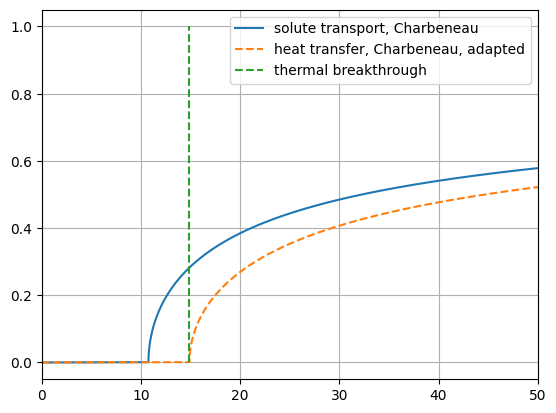

Der Einflussbereich im Aquitard beträgt 52.07m


In [23]:
import numpy as np
import matplotlib.pyplot as plt

diameter = 4000     # Durchmesser Gebiet

tmax = 50

a = 450             # Halber Abstand der Bohrungen
Q = 0.03            # Injektionsrate (m³/s)
dwell = 0.3         # Durchmesser der Bohrung


lc = diameter / 10  #



M = 30             # Mächtigkeit des Aquifers (m)
dM = 1             # Abstand des Brunnens zum Aquifer
phi = 0.4          # Porosität des Aquifers
rho_S = 1900         # Dichte 
c_S = 850             # Wärmekapazität
lambda_S = 3.0      # Wärmeleitfähigkeit

# Fluid
rho_F = 1500
c_F = 4200

a2s = 365*24*3600   # Umrechnung von Sekunden in Jahre

rho_A_c_A = phi * rho_F * c_F + (1 - phi) * rho_S * c_S
L = np.sqrt(2*tmax*a2s*lambda_S/rho_A_c_A)
L0 = 0.01

# Analytical solution


# Durchbruchszeit bestimmen
rho_A_c_A = phi * rho_F * c_F + (1 - phi) * rho_S * c_S
G = rho_A_c_A / (rho_F * c_F)
tb = G * 4 * np.pi * M * a * a / (3 * Q) /a2s

F = np.linspace(1e-20, 1, 1000)
tf = 4 *np.pi * phi * M * a * a / Q * (1 - np.pi * F / np.tan(np.pi * F)) / (np.sin(np.pi * F) ** 2) / a2s
tau2 = G*tf/phi

print("Note: the solution for heat transfer does not consider heat exchange with the aquitard.")

plt.plot(tf, F, label="solute transport, Charbeneau")
plt.plot(tau2, F, '--', label="heat transfer, Charbeneau, adapted")
plt.plot([tb, tb], [0, 1], '--', label="thermal breakthrough")

plt.grid()
plt.xlim((0, tmax))
plt.legend()
plt.show()




print(f"Der Einflussbereich im Aquitard beträgt {L:.2f}m")

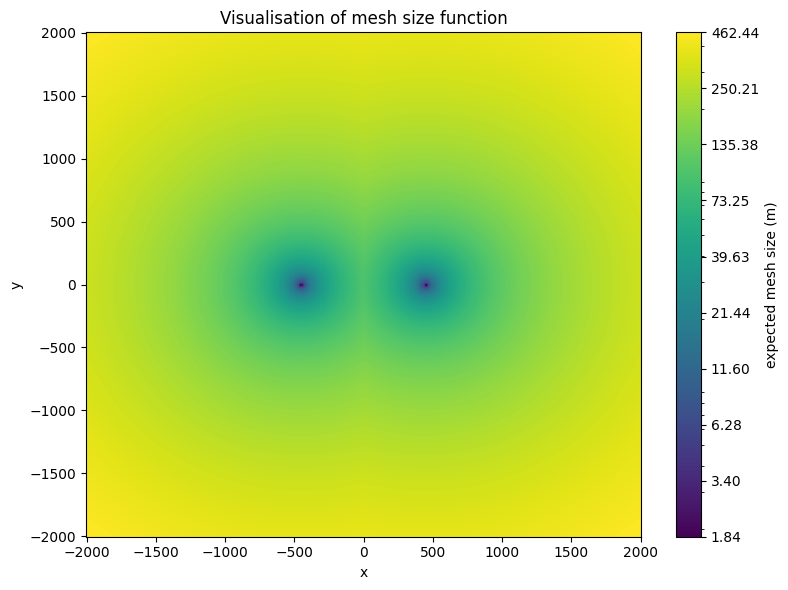

In [24]:
#Install gmsh without X11 dependency
#!pip install -i https://gmsh.info/python-packages-dev-nox --force-reinstall --no-cache-dir gmsh
#!pip install pygmsh

import pygmsh
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def field(x, y, d):
    return 0.4*np.power(np.sqrt((x+d)*(x+d) + y*y), 0.9)+dwell/2

def doublet(x, y, d):
    return np.minimum(field(x, y, -d), field(x, y, d))

# Parameter
x_range = np.linspace(-diameter/2, diameter/2, 500)
y_range = np.linspace(-diameter/2, diameter/2, 500)
X, Y = np.meshgrid(x_range, y_range)

# Feld berechnen
Z = doublet(X, Y, d=a)

# Wertebereich festlegen
z_min = np.min(Z)
z_max = np.max(Z)

# Plot mit logarithmischer Farbskala
plt.figure(figsize=(8, 6))
plt.pcolormesh(X, Y, Z, shading='auto', norm=LogNorm(vmin=z_min, vmax=z_max), cmap='viridis')
cbar = plt.colorbar(label='expected mesh size (m)')
plt.title('Visualisation of mesh size function')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()

ticks = np.geomspace(z_min, z_max, 10)  # Beispiel: min, mittel, max
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{tick:.2f}" for tick in ticks])


plt.show()

c:\Users\jante\Anaconda3\envs\python_310\lib\site-packages\pygmsh\occ\geometry.py:221: UserWarning: Specified mesh size for <pygmsh Disk object, ID 1> discarded in Boolean difference operation.
  warnings.warn(
c:\Users\jante\Anaconda3\envs\python_310\lib\site-packages\pygmsh\occ\geometry.py:221: UserWarning: Specified mesh size for <pygmsh Disk object, ID 2> discarded in Boolean difference operation.
  warnings.warn(


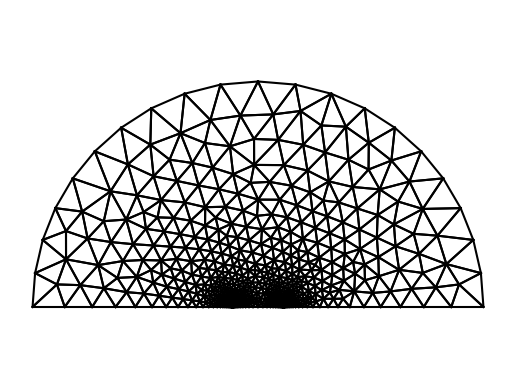

In [25]:
with pygmsh.occ.Geometry() as geom:

    #Disk as base geometry
    disk_domain = geom.add_disk([0.0, 0.0], diameter, mesh_size=lc)

    #Add injection and extraction well as points in the geometry
    for b in [-a, a]:
        #p = geom.add_point([b, 0, 0], mesh_size=0.1)
        #geom.boolean_fragments([disk], [p], delete_other=False)

        disk_well = geom.add_disk([b, 0.0], dwell, mesh_size=dwell/2)
        geom.boolean_difference(disk_domain, disk_well)

    #
    rectangle = [geom.add_rectangle([-diameter, -diameter, 0.0], 2*diameter, diameter)]
    geom.boolean_difference(disk_domain, rectangle)

    geom.set_mesh_size_callback(
        lambda dim, tag, x, y, z, lc: doublet(x,y,a)
    )

    mesh = geom.generate_mesh()

triangles = mesh.cells_dict["triangle"]
points = mesh.points

pts = points[:, :2]
for e in triangles:
    for idx in [[0, 1], [1, 2], [2, 0]]:
        X = pts[e[idx]]
        plt.plot(X[:, 0], X[:, 1], "-k")

plt.gca().set_aspect("equal", "datalim")
plt.axis("off")
plt.show()

mesh.write("domain.vtu")

In [26]:
import pyvista as pv
from geo import layersfromsurf

pv.set_jupyter_backend('trame')

scenario = 1


if scenario == 1:
    nAquifer = 1

elif scenario == 2:
    nAquifer = 3
    nAquitard = 5

    phiAquitard = 0.1
    KAquitard = 1e-14

KAquifer = 1e-10


for file in ["domain.vtu"]:

    mesh2d = pv.read(file)

    if scenario == 1:
        thickness = np.array([M])

    elif scenario == 2:
        pAquitard = np.geomspace(L0, L, nAquitard+2)
        dAquitard = np.diff(pAquitard)
        thickness = np.hstack((np.flip(dAquitard), 
                            np.array([dM]),
                            np.array([(M-dM)/2/nAquifer] * nAquifer)))

    mesh3d = layersfromsurf(mesh2d, thickness)

    mesh3d["porosity"] = np.repeat(phi, mesh3d.number_of_cells)
    mesh3d["permeability"] = np.repeat(KAquifer, mesh3d.number_of_cells)

    if scenario == 2:
        mesh3d["porosity"][mesh3d["Layer"] <= nAquitard] = phiAquitard
        mesh3d["permeability"][mesh3d["Layer"] <= nAquitard] = KAquifer 

    #mesh3d["Porosity"][mesh3d["Layer"] > (nAquitard+nAquifer)] = phiAquitard
    #mesh3d["Permeability"][mesh3d["Layer"] > (nAquitard+nAquifer)] = KAquitard

    # Add info for OGS
    mesh3d.point_data["bulk_node_ids"] = np.arange(0, mesh3d.n_points, dtype=np.uint64)
    mesh3d.cell_data["bull_element_ids"] = np.arange(0, mesh3d.n_cells, dtype=np.uint64)

    mesh3d.save(file)


#mesh3d.plot(scalars="Layer", show_edges=True, cmap="viridis")
mesh3d.plot(scalars="porosity", show_edges=True, cmap="Pastel1")

Widget(value='<iframe src="http://localhost:51547/index.html?ui=P_0x137e30aa6e0_5&reconnect=auto" class="pyvis…

In [27]:
surf = mesh3d.extract_surface()
cell_normals = surf.cell_normals

# Define surface normals and names
n_vectors = [[0, 0, -1], [0, 0, 1], [0, 1, 0]]
surf_names = ["bottom", "top", "profile"]
eps = 1e-8

#all_selected = np.array([], dtype=int)
all_selected = np.array([])

# Select surface cells based on normal vectors
for n, name in zip(n_vectors, surf_names):
    l2 = np.linalg.norm(cell_normals - n, axis=1)
    ids = np.where(l2 < eps)[0]

    if ids.size > 0:
        subset = surf.extract_cells(ids)
        subset.save(f"{name}.vtu")
        all_selected = np.concatenate((all_selected, ids))
        print(f"{name} extracted...")
    else:
        print(f"Warning: {name} mesh has no cells...")

# Identify unselected surface cells
unselected_ids = np.setdiff1d(np.arange(surf.n_cells), all_selected)
unselected = surf.extract_cells(unselected_ids)
centers = unselected.cell_centers().points[:,:2] #ignore z-value

# Define classification centers and names
radius = 5*dwell
targets = [[b, 0], [-b, 0]]
names = ["injection", "extraction"]

classified_ids = np.array([], dtype=int)

# Classify injection and extraction cells by distance
for pt, name in zip(targets, names):
    dist = np.linalg.norm(centers - np.array(pt), axis=1)
    ids = np.where(dist < radius)[0]

    if ids.size > 0:
        subset = unselected.extract_cells(ids)
        subset.save(f"{name}.vtu")
        classified_ids = np.concatenate((classified_ids, ids))
        print(f"{name} extracted...")
    else:
        print(f"Warning: {name} mesh has no cells...")

# Remaining cells are boundary
boundary_ids = np.setdiff1d(np.arange(unselected.n_cells), classified_ids)
if boundary_ids.size > 0:
    unselected.extract_cells(boundary_ids).save("boundary.vtu")
else:
    print("Warning: boundary mesh has no cells...")
        

bottom extracted...
top extracted...
profile extracted...
injection extracted...
extraction extracted...


In [34]:
mesh2d = pv.read("injection.vtu")
mesh2d.plot(show_edges=True, cmap="Pastel1")

# Calculate surface area
surface_area = mesh2d.area
print(f"The surface area is: {surface_area:.2f} m²")

print(dwell*np.pi*M)


Widget(value='<iframe src="http://localhost:51547/index.html?ui=P_0x137cd299630_9&reconnect=auto" class="pyvis…

The surface area is: 27.55 m²
28.274333882308138


In [29]:
mesh2d = pv.read("extraction.vtu")
mesh2d.plot(show_edges=True, cmap="Pastel1")

# Calculate surface area
surface_area = mesh2d.area
print(f"The surface area is: {surface_area:.2f} m²")


Widget(value='<iframe src="http://localhost:51547/index.html?ui=P_0x137e325b250_7&reconnect=auto" class="pyvis…

The surface area is: 27.55 m²


In [30]:
# Add bulk_node_ids with OGSTools

!identifySubdomains -m domain.vtu -- extraction.vtu
!identifySubdomains -m domain.vtu -- injection.vtu
!identifySubdomains -m domain.vtu -- top.vtu
!identifySubdomains -m domain.vtu -- bottom.vtu
!identifySubdomains -m domain.vtu -- boundary.vtu
!identifySubdomains -m domain.vtu -- profile.vtu

Der Befehl "identifySubdomains" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Der Befehl "identifySubdomains" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Der Befehl "identifySubdomains" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Der Befehl "identifySubdomains" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Der Befehl "identifySubdomains" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Der Befehl "identifySubdomains" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


In [31]:
!NodeReordering -i domain.vtu -o domain.vtu
!checkMesh -v domain.vtu
print("-------------------------------------------------------------------------------")
!checkMesh -v injection.vtu
print("-------------------------------------------------------------------------------")
!checkMesh -v extraction.vtu
print("-------------------------------------------------------------------------------")
!checkMesh -v boundary.vtu

Der Befehl "NodeReordering" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Der Befehl "checkMesh" ist entweder falsch geschrieben oder

-------------------------------------------------------------------------------



konnte nicht gefunden werden.
Der Befehl "checkMesh" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------


Der Befehl "checkMesh" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Der Befehl "checkMesh" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


In [32]:
import ogstools as ogs

# Simulate problem with TwoPhaseFlowPP and TH2M
prj_file = r"doublet.prj"

prj = ogs.Project(input_file=prj_file, output_file=prj_file)
#prj.write_input()        
prj.run_model()

ModuleNotFoundError: No module named 'ogstools'

In [ ]:
import pyvista as pv
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

def parse_pvd(pvd_file):
    # XML einlesen und parsen
    tree = ET.parse(pvd_file)
    root = tree.getroot()

    # Listen für timestep und file
    timesteps = []
    files = []

    # Alle DataSet-Elemente durchgehen
    for dataset in root.find("Collection").findall("DataSet"):
        timesteps.append(float(dataset.attrib["timestep"]))
        files.append(dataset.attrib["file"])

    return timesteps, files


def mean_over_time(pvd_file, domain_vtu, roi_vtu, field):

    output = list()
    
    timesteps, files = parse_pvd(pvd_file)

    # ROI-Datei laden
    roi_mesh = pv.read(roi_vtu)
    roi_ids = roi_mesh.point_data["bulk_node_ids"]

    # Domain laden
    domain_mesh = pv.read(domain_vtu)
    domain_ids = domain_mesh.point_data["bulk_node_ids"]

    # Maske: Welche Punkte im Ziel-Mesh gehören zur ROI?
    mask = np.isin(domain_ids, roi_ids)

    for file in files:

        # Ziel-VTU-Datei laden
        target_mesh = pv.read(file)
        
        # Temperaturwerte an diesen Punkten extrahieren
        roi_field = target_mesh.point_data[field][mask]
        
        # Mittelwert berechnen
        mean_field = np.mean(roi_field)

        output.append(mean_field)

    return np.array(timesteps), np.array(output)

time, temperature = mean_over_time("geothermal_doublet.pvd", "domain.vtu", "extraction.vtu", "temperature")

seconds_per_year = 60*60*24*365

plt.plot(time/seconds_per_year, temperature, label="HT model")
plt.plot(tau2, F, '--', label="analytical")
plt.plot([tb, tb], [0, 1], '--', label="thermal breakthrough")
plt.xlabel("time (a)")
plt.ylabel("temperature (-)")
plt.grid()
plt.xlim((0, tmax))
plt.legend()
plt.show()